In [1]:
import os
print(os.getcwd()) # check the current working directory

# os.chdir('C:\\Users\\u5819317\\MikeMike\\Zhuoran Liu_S1 2019\\PythonProjection\\Leisure_1') # change the current working directory
# print(os.getcwd())

In [2]:
## Initial setting

import pandas as pd
interestTable = pd.read_csv('return_H.csv', usecols=[1,2,3])  ## Import interest rate
mortalityTable = pd.read_csv('newmort2.csv', usecols=[1,2,3])  ## Import mortality table

import numpy as np
from datascience import Table
Expectation = Table.from_df(interestTable)  ## Convert readin csv file to 'table'

α = 0.9
ρ = 5
β = 1

grids = 40
Upper_grid = 2000000.0
Lower_grid = Upper_grid / grids
A109 = np.arange(Lower_grid, Upper_grid+1, int(Upper_grid/grids))
print(A109)

Y1 = 85000 # prior retirement income
Y2 = 30000 # post retirement income

θ = 0.5 ## Constant assets allocation rate

import matplotlib.pyplot as plt
%matplotlib inline

[  50000.  100000.  150000.  200000.  250000.  300000.  350000.  400000.
  450000.  500000.  550000.  600000.  650000.  700000.  750000.  800000.
  850000.  900000.  950000. 1000000. 1050000. 1100000. 1150000. 1200000.
 1250000. 1300000. 1350000. 1400000. 1450000. 1500000. 1550000. 1600000.
 1650000. 1700000. 1750000. 1800000. 1850000. 1900000. 1950000. 2000000.]


### 1. Solve for age 109

In [3]:
# from scipy.optimize import root # only useful when trying to find optimal assets allocation rate through root finding

θ109 = θ
def Optimal_109():
    leisure1 = 1 + (1-θ)*Expectation.column('Bond') + θ*Expectation.column('Eq') # (1+i)
    leisure2 = np.power(leisure1, α*(1-ρ)) * Expectation.column('Probability') # Expectation
    leisure3 = β * (1-mortalityTable['X'][108]) * leisure2.sum() # A number
    leisure4 = np.power((1-α)*A109/(α*Y2), α*(1-ρ)-1) * leisure3 # A vector for diffrent A109
    leisure5 = np.power(leisure4, -1/ρ) ## Unconstraint leisure
    leisure5[leisure5 <= 2/7] = 2/7 ## Add constraint on leisure
    leisure5[leisure5 >= 1] = 1
    
    consum1 = leisure3 / (np.power(leisure5, (1-α)*(1-ρ)))
    consum2 = np.power(consum1, 1/(α*(1-ρ)-1))
    consum3 = A109 * consum2
    return consum3, leisure5

C109, L109 = Optimal_109()
M109 = A109 - Y2*(1-L109) + C109

print('Optimal consumption at 109 is ' + str(C109))
print('Constrained optimal leisure time at 109 is ' + str(L109))

Optimal consumption at 109 is [  64604.84621679  123986.71193164  180044.18580869  234597.15383058
  289684.21878058  347621.0625367   405557.90629282  463494.75004894
  521431.59380505  579368.43756117  637305.28131729  695242.1250734
  753178.96882952  811115.81258564  869052.65634175  926989.50009787
  984926.34385399 1042863.1876101  1100800.03136622 1158736.87512234
 1216673.71887845 1274610.56263457 1332547.40639069 1390484.25014681
 1448421.09390292 1506357.93765904 1564294.78141516 1622231.62517127
 1680168.46892739 1738105.31268351 1796042.15643962 1853979.00019574
 1911915.84395186 1969852.68770797 2027789.53146409 2085726.37522021
 2143663.21897632 2201600.06273244 2259536.90648856 2317473.75024467]
Constrained optimal leisure time at 109 is [0.28571429 0.45921004 0.66683032 0.86887835 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 

### 2. Solve for age 108-65

In [4]:
Optimal_results_EGM = Table().with_columns([
    'A109', A109,
    'C109', C109,
    'L109', L109,
    'M109', M109,
])
Optimal_θx = Table()

from scipy.interpolate import interp1d
def solve_108_65(A, age, income, table, raa=θ):
    '''
    solve for optimal consumption and leisure for age 108-65
    only constraints on leisure, no constraints on consumption
    '''
    interest = 1 + raa*Expectation.column('Eq') + (1-raa)*Expectation.column('Bond') ##two global vectors
    Interpolation_C = interp1d(table.column(4*(108-age)+3), table.column(4*(108-age)+1), \
                               kind='linear', fill_value='extrapolate')
    Interpolation_L = interp1d(table.column(4*(108-age)+3), table.column(4*(108-age)+2), \
                               kind='linear', fill_value='extrapolate')
    C_next = Interpolation_C(A * interest) # this is a vector
    L_next = Interpolation_L(A * interest)
    
    numerator_L = β*(1-mortalityTable['X'][age-1]) * (α * np.power(C_next,α*(1-ρ)-1) * np.power(L_next,(1-α)*(1-ρ))\
                                                    *interest*Expectation.column('Probability')).sum()
    denominator_L = α * np.power((α*income)/(1-α), α*(1-ρ)-1)
    L_new = np.power(numerator_L / denominator_L, -1/ρ)
    if L_new <= 2/7:
        L_new = 2/7
    elif L_new > 1:
        L_new = 1
    
    denominator_C = α * np.power(L_new, (1-α)*(1-ρ))
    C_new = np.power(numerator_L / denominator_C, 1/(α*(1-ρ)-1))
    return C_new, L_new

In [5]:
import time
start_time = time.time()

for i in range(44): # age 108-65 -> i 0-43
    Ax = A109
    Optimal_results_EGM = Optimal_results_EGM.with_column('A%1d'%(108-i), Ax)
    Cx = [] 
    Lx = []
    
    for node in Ax:
        Cxx, Lxx = solve_108_65(A=node, age=108-i, income=Y2, table=Optimal_results_EGM)
        Cx.append(Cxx)
        Lx.append(Lxx)
    
    Optimal_results_EGM = Optimal_results_EGM.with_column('C%1d'%(108-i), Cx)
    Optimal_results_EGM = Optimal_results_EGM.with_column('L%1d'%(108-i), Lx)
    Mx = Ax - Y2*(1-np.array(Lx)) + Cx
    Optimal_results_EGM = Optimal_results_EGM.with_column('M%1d'%(108-i), Mx)

print("--- %s seconds ---" % (time.time() - start_time))

Optimal_results_EGM.show(3)

--- 0.442150354385376 seconds ---


A109,C109,L109,M109,A108,C108,L108,M108,A107,C107,L107,M107,A106,C106,L106,M106,A105,C105,L105,M105,A104,C104,L104,M104,A103,C103,L103,M103,A102,C102,L102,M102,A101,C101,L101,M101,A100,C100,L100,M100,A99,C99,L99,M99,A98,C98,L98,M98,A97,C97,L97,M97,A96,C96,L96,M96,A95,C95,L95,M95,A94,C94,L94,M94,A93,C93,L93,M93,A92,C92,L92,M92,A91,C91,L91,M91,A90,C90,L90,M90,A89,C89,L89,M89,A88,C88,L88,M88,A87,C87,L87,M87,A86,C86,L86,M86,A85,C85,L85,M85,A84,C84,L84,M84,A83,C83,L83,M83,A82,C82,L82,M82,A81,C81,L81,M81,A80,C80,L80,M80,A79,C79,L79,M79,A78,C78,L78,M78,A77,C77,L77,M77,A76,C76,L76,M76,A75,C75,L75,M75,A74,C74,L74,M74,A73,C73,L73,M73,A72,C72,L72,M72,A71,C71,L71,M71,A70,C70,L70,M70,A69,C69,L69,M69,A68,C68,L68,M68,A67,C67,L67,M67,A66,C66,L66,M66,A65,C65,L65,M65
50000,64604.8,0.285714,93176.3,50000,47143.5,0.285714,75714.9,50000,42162.5,0.285714,70733.9,50000,40196.8,0.285714,68768.2,50000,39376.3,0.285714,67947.8,50000,39075.7,0.285714,67647.1,50000,39024,0.285714,67595.4,50000,39103.2,0.285714,67674.6,50000,39238.5,0.285714,67809.9,50000,39380.9,0.285714,67952.4,50000,39497.2,0.285714,68068.6,50000,39602.8,0.285714,68174.2,50000,39658.4,0.285714,68229.8,50000,39637.9,0.285714,68209.3,50000,39525.8,0.285714,68097.2,50000,39315.2,0.285714,67886.6,50000,39006.1,0.285714,67577.6,50000,38604.9,0.285714,67176.3,50000,38122.5,0.285714,66693.9,50000,37574,0.285714,66145.4,50000,36976.6,0.285714,65548,50000,36345.6,0.285714,64917.1,50000,35694,0.285714,64265.4,50000,35032.1,0.285714,63603.5,50000,34368.6,0.285714,62940.1,50000,33710.6,0.285714,62282,50000,33063.5,0.285714,61634.9,50000,32431.7,0.285714,61003.1,50000,31818.4,0.285714,60389.8,50000,31226,0.285714,59797.4,50000,30656,0.285714,59227.5,50000,30109.5,0.285714,58680.9,50000,29586.7,0.285714,58158.1,50000,29087.4,0.285714,57658.8,50000,28611.4,0.285714,57182.8,50000,28158.2,0.285714,56729.6,50000,27727.3,0.285714,56298.8,50000,27318.2,0.285714,55889.7,50000,26930.1,0.285714,55501.6,50000,26562.3,0.285714,55133.7,50000,26213.8,0.285714,54785.2,50000,25883.7,0.285714,54455.1,50000,25570.9,0.285714,54142.3,50000,25274.4,0.285714,53845.8,50000,24992.9,0.285714,53564.4
100000,123987,0.45921,207763,100000,78374.7,0.290277,157083,100000,64330.9,0.285714,142902,100000,57848.8,0.285714,136420,100000,54323.7,0.285714,132895,100000,52215.7,0.285714,130787,100000,50863.4,0.285714,129435,100000,49959.4,0.285714,128531,100000,49320.5,0.285714,127892,100000,48831.8,0.285714,127403,100000,48418.2,0.285714,126990,100000,48075.3,0.285714,126647,100000,47738.6,0.285714,126310,100000,47365.3,0.285714,125937,100000,46928.7,0.285714,125500,100000,46414.6,0.285714,124986,100000,45818.6,0.285714,124390,100000,45144.1,0.285714,123716,100000,44400.9,0.285714,122972,100000,43603.7,0.285714,122175,100000,42770.2,0.285714,121342,100000,41915.8,0.285714,120487,100000,41053.2,0.285714,119625,100000,40192.9,0.285714,118764,100000,39343,0.285714,117914,100000,38510.2,0.285714,117082,100000,37699.4,0.285714,116271,100000,36914.5,0.285714,115486,100000,36158.1,0.285714,114730,100000,35432.2,0.285714,114004,100000,34737.6,0.285714,113309,100000,34074.7,0.285714,112646,100000,33443.4,0.285714,112015,100000,32842.8,0.285714,111414,100000,32272.2,0.285714,110844,100000,31730.6,0.285714,110302,100000,31217.2,0.285714,109789,100000,30730.8,0.285714,109302,100000,30270.5,0.285714,108842,100000,29835,0.285714,108406,100000,29423.2,0.285714,107995,100000,29033.7,0.285714,107605,100000,28665.2,0.285714,107237,100000,28316.3,0.285714,106888,100000,27985.5,0.285714,106557
150000,180044,0.66683,320049,150000,107587,0.39847,239541,150000,85723.2,0.317493,215248,150000,75438.9,0.285714,204010,150000,69228.1,0.285714,197800,150000,65315.9,0.285714,193887,150000,62663.5,0.285714,191235,150000,60776.5,0.285714,189348,150000,59363.8,0.285714,187935,150000,58244.8,0.285714,186816,150000,57302.1,0.285714,185874,150000,56511.6,0.285714,185083,150000,55783.5,0.285714,184355,150000,55058.3,0.285714,183630,150000,54298.2,0.285714,182870,150000,53

In [6]:
def solve_64(A, age, income, table, raa=θ):
    '''
    solve for optimal consumption and leisure for age 64
    constraints on both leisure and consumption
    '''
    interest = 1 + raa*Expectation.column('Eq') + (1-raa)*Expectation.column('Bond') ##two global vectors
    Interpolation_C = interp1d(table.column(4*(108-age)+3), table.column(4*(108-age)+1), \
                               kind='linear', fill_value='extrapolate')
    Interpolation_L = interp1d(table.column(4*(108-age)+3), table.column(4*(108-age)+2), \
                               kind='linear', fill_value='extrapolate')
    C_next = Interpolation_C(A * interest) # this is a vector
    L_next = Interpolation_L(A * interest)
    numerator_L = β*(1-mortalityTable['X'][age-1]) * (α * np.power(C_next,α*(1-ρ)-1) * np.power(L_next,(1-α)*(1-ρ)) \
                                                     * interest*Expectation.column('Probability')).sum()
    denominator_L = α * np.power((α*income)/(1-α), α*(1-ρ)-1)
    L_new = np.power(numerator_L / denominator_L, -1/ρ)
    L_uncon = L_new  
    if L_new <= 2/7:
        L_new = 2/7
    elif L_new > 1:
        L_new = 1

    denominator_C = α * np.power(L_new, (1-α)*(1-ρ))
    C_new = np.power(numerator_L / denominator_C, 1/(α*(1-ρ)-1))
    C_uncon = C_new
    
    if C_new > income: ## check constraints on consumption
        C_new = income
        L_new = np.power(numerator_L * income / ((1-α)*np.power(C_new,α*(1-ρ)))\
                         , 1/((1-α)*(1-ρ)-1)) # recalculate optimal leisure
        L_uncon = L_new
        if L_new <= 2/7: # re-check constraints on leisure
            L_new = 2/7          
        elif L_new > 1:
            L_new = 1

    return C_new, L_new, C_uncon, L_uncon

A64 = A109
C64 = [] 
L64 = []
C_un64 = []
L_un64 = []

for node in A64:
    Cxx, Lxx, C_uncon, L_uncon = solve_64(A=node, age=64, income=Y1, table=Optimal_results_EGM)
    L64.append(Lxx) 
    C64.append(Cxx)
    C_un64.append(C_uncon)
    L_un64.append(L_uncon)
    
M64 = A64 - Y1*(1-np.array(L64)) + C64
Optimal_results_EGM_64 = Table().with_columns([
    'A64', A64,
    'C64', C64,
    'L64', L64,
    'M64', M64,
    'C_un64', C_un64,
    'L_un64', L_un64,
])

Optimal_results_EGM_64.show(3)

A64,C64,L64,M64,C_un64,L_un64
50000,24725.6,0.285714,14011.3,24725.6,0.0384769
100000,27671.7,0.285714,66957.4,27671.7,0.0426755
150000,30576.4,0.285714,119862,30576.4,0.0467801


In [28]:
def solve_63_25(A, age, income, table, raa=θ):
    '''
    solve for optimal consumption and leisure for age 63-25
    constraints on both leisure and consumption
    '''
    interest = 1 + raa*Expectation.column('Eq') + (1-raa)*Expectation.column('Bond') ##two global vectors
    
    Interpolation_C2 = interp1d(table.column(6*(63-age)+3), table.column(6*(63-age)+4), \
                               kind='linear', fill_value='extrapolate')
    Interpolation_L = interp1d(table.column(6*(63-age)+3), table.column(6*(63-age)+2), \
                               kind='linear', fill_value='extrapolate')
    C_next2 = Interpolation_C2(A * interest) # unconstrained consumption
    L_next = Interpolation_L(A * interest) # constrained leisure
    
    Interpolation_L2 = interp1d(table.column(6*(63-age)+3), table.column(6*(63-age)+5), \
                               kind='linear', fill_value='extrapolate')
    Interpolation_C = interp1d(table.column(6*(63-age)+3), table.column(6*(63-age)+1), \
                               kind='linear', fill_value='extrapolate')
    C_next = Interpolation_C(A * interest) # constrained consumption
    L_next2 = Interpolation_L2(A * interest) # unconstrained leisure

    denominator_L = α * np.power((α*income)/(1-α), α*(1-ρ)-1)
    
#     print([C_next2<income])
    numerator_L1 = β*(1-mortalityTable['X'][age-1]) * ((α * np.power(C_next2[C_next2<income],α*(1-ρ)-1) \
                  * np.power(L_next[C_next2<income],(1-α)*(1-ρ)) ) * interest[C_next2<income] \
                  * Expectation.column('Probability')[C_next2<income] ).sum()    
    numerator_L2 = β*(1-mortalityTable['X'][age-1]) * (((1-α) * np.power(income,α*(1-ρ)) \
                  * np.power(L_next2[C_next2>income],(1-α)*(1-ρ)-1) ) * interest[C_next2>income] \
                  * Expectation.column('Probability')[C_next2>income] ).sum() / income    
    RHS = numerator_L1+numerator_L2
    L_new = np.power(RHS / denominator_L, -1/ρ)
    L_uncon = L_new

    if L_new <= 2/7:
        L_new = 2/7
    elif L_new > 1:
        L_new = 1
    denominator_C = α * np.power(L_new, (1-α)*(1-ρ))
    C_new = np.power(RHS / denominator_C, 1/(α*(1-ρ)-1))
    C_uncon = C_new

    if C_new > income: ## check constraints on consumption
        C_new = income
        L_new = np.power(RHS * income / ((1-α)*np.power(C_new,α*(1-ρ))), 1/((1-α)*(1-ρ)-1))
        L_uncon = L_new

        if L_new < 2/7:
            L_new = 2/7           
        elif L_new > 1:
            L_new = 1

                
# This code just doesn't apply here -- L_next.mean() >= 1            

    return C_new, L_new, C_uncon, L_uncon

In [29]:
import time
start_time = time.time()
Optimal_results_EGM_25_63 = Table().with_columns([
    'A64', A64,
    'C64', C64,
    'L64', L64,
    'M64', M64,
    'C_un64', C_un64,
    'L_un64', L_un64,
])

for i in range(39): ## age 63-25 --> i from 0 to 38 (include)
    Ax = A109
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('A%1d'%(63-i), Ax)
    Cx = [] 
    Lx = []
    C_unx = []
    L_unx = []
    
    for node in Ax:
        Cxx, Lxx, C_unxx, L_unxx = solve_63_25(A=node, age=63-i, income=Y1, table=Optimal_results_EGM_25_63)
        Lx.append(Lxx) 
        Cx.append(Cxx)
        C_unx.append(C_unxx)
        L_unx.append(L_unxx)
        
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('C%1d'%(63-i), Cx)
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('L%1d'%(63-i), Lx)
    Mx = Ax - Y1*(1-np.array(Lx)) + Cx
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('M%1d'%(63-i), Mx)
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('C_un%1d'%(63-i), C_unx)
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('L_un%1d'%(63-i), L_unx)

print("--- %s seconds ---" % (time.time() - start_time))

Optimal_results_EGM_25_63.show(3)

--- 0.8001599311828613 seconds ---


A64,C64,L64,M64,C_un64,L_un64,A63,C63,L63,M63,C_un63,L_un63,A62,C62,L62,M62,C_un62,L_un62,A61,C61,L61,M61,C_un61,L_un61,A60,C60,L60,M60,C_un60,L_un60,A59,C59,L59,M59,C_un59,L_un59,A58,C58,L58,M58,C_un58,L_un58,A57,C57,L57,M57,C_un57,L_un57,A56,C56,L56,M56,C_un56,L_un56,A55,C55,L55,M55,C_un55,L_un55,A54,C54,L54,M54,C_un54,L_un54,A53,C53,L53,M53,C_un53,L_un53,A52,C52,L52,M52,C_un52,L_un52,A51,C51,L51,M51,C_un51,L_un51,A50,C50,L50,M50,C_un50,L_un50,A49,C49,L49,M49,C_un49,L_un49,A48,C48,L48,M48,C_un48,L_un48,A47,C47,L47,M47,C_un47,L_un47,A46,C46,L46,M46,C_un46,L_un46,A45,C45,L45,M45,C_un45,L_un45,A44,C44,L44,M44,C_un44,L_un44,A43,C43,L43,M43,C_un43,L_un43,A42,C42,L42,M42,C_un42,L_un42,A41,C41,L41,M41,C_un41,L_un41,A40,C40,L40,M40,C_un40,L_un40,A39,C39,L39,M39,C_un39,L_un39,A38,C38,L38,M38,C_un38,L_un38,A37,C37,L37,M37,C_un37,L_un37,A36,C36,L36,M36,C_un36,L_un36,A35,C35,L35,M35,C_un35,L_un35,A34,C34,L34,M34,C_un34,L_un34,A33,C33,L33,M33,C_un33,L_un33,A32,C32,L32,M32,C_un32,L_un32,A31,C31,L31,M31,C_un31,L_un31,A30,C30,L30,M30,C_un30,L_un30,A29,C29,L29,M29,C_un29,L_un29,A28,C28,L28,M28,C_un28,L_un28,A27,C27,L27,M27,C_un27,L_un27,A26,C26,L26,M26,C_un26,L_un26,A25,C25,L25,M25,C_un25,L_un25
50000,24725.6,0.285714,14011.3,24725.6,0.0384769,50000,26637.6,0.285714,15923.3,26637.6,0.0412061,50000,28376.9,0.285714,17662.6,28376.9,0.043675,50000,29962.1,0.285714,19247.8,29962.1,0.0459147,50000,31410.5,0.285714,20696.2,31410.5,0.0479529,50000,32737.2,0.285714,22022.9,32737.2,0.0498131,50000,33954.9,0.285714,23240.6,33954.9,0.0515153,50000,35074.9,0.285714,24360.6,35074.9,0.0530765,50000,36106.6,0.285714,25392.3,36106.6,0.0545112,50000,37058.4,0.285714,26344.1,37058.4,0.0558318,50000,37937.5,0.285714,27223.2,37937.5,0.0570492,50000,38750.3,0.285714,28036,38750.3,0.0581726,50000,39502.3,0.285714,28788,39502.3,0.0592105,50000,40198.9,0.285714,29484.6,40198.9,0.0601704,50000,40844.5,0.285714,30130.2,40844.5,0.0610589,50000,41443.3,0.285714,30729,41443.3,0.061882,50000,41999.2,0.285714,31284.9,41999.2,0.0626451,50000,42515.4,0.285714,31801.1,42515.4,0.0633532,50000,42995.1,0.285714,32280.8,42995.1,0.0640106,50000,43441.2,0.285714,32726.9,43441.2,0.0646212,50000,43856.1,0.285714,33141.8,43856.1,0.0651889,50000,44242.3,0.285714,33528,44242.3,0.0657168,50000,44601.9,0.285714,33887.6,44601.9,0.066208,50000,44936.8,0.285714,34222.5,44936.8,0.0666654,50000,45249,0.285714,34534.7,45249,0.0670913,50000,45540,0.285714,34825.7,45540,0.0674882,50000,45811.4,0.285714,35097.1,45811.4,0.0678581,50000,46064.6,0.285714,35350.3,46064.6,0.0682031,50000,46300.9,0.285714,35586.7,46300.9,0.0685249,50000,46521.6,0.285714,35807.3,46521.6,0.0688253,50000,46727.7,0.285714,36013.4,46727.7,0.0691058,50000,46920.2,0.285714,36206,46920.2,0.0693677,50000,47100.2,0.285714,36385.9,47100.2,0.0696125,50000,47268.4,0.285714,36554.2,47268.4,0.0698412,50000,47425.8,0.285714,36711.5,47425.8,0.070055,50000,47573,0.285714,36858.7,47573,0.070255,50000,47710.7,0.285714,36996.5,47710.7,0.0704422,50000,47839.8,0.285714,37125.5,47839.8,0.0706174,50000,47960.7,0.285714,37246.4,47960.7,0.0707816,50000,48074.1,0.285714,37359.8,48074.1,0.0709356
100000,27671.7,0.285714,66957.4,27671.7,0.0426755,100000,29514.4,0.285714,68800.1,29514.4,0.0452832,100000,31190,0.285714,70475.7,31190,0.0476431,100000,32718.2,0.285714,72003.9,32718.2,0.0497866,100000,34115.8,0.285714,73401.5,34115.8,0.0517398,100000,35396.8,0.285714,74682.6,35396.8,0.0535246,100000,36573.6,0.285714,75859.3,36573.6,0.0551595,100000,37656.5,0.285714,76942.2,37656.5,0.0566603,100000,38654.6,0.285714,77940.3,38654.6,0.0580404,100000,39575.6,0.285714,78861.3,39575.6,0.0593116,100000,40426.5,0.285714,79712.2,40426.5,0.0604838,100000,41213.2,0.285714,80499,41213.2,0.0615659,100000,41941.3,0.285714,81227,41941.3,0.0625657,100000,42615.5,0.285714,81901.3,42615.5,0.0634905,100000,43240.4,0.285714,82526.1,43240.4,0.0643465,100000,43819.9,0.285714,83105.6,43819.9,0.0651394,100000,44357.7,0.285714,83643.4,44357.7,0.0658745,100000,44857,0.285714,841

# VFI v2.0

In [9]:
## Initial setting
M110 = np.arange(Lower_grid, Upper_grid+1, int(Upper_grid/grids))
interest = (1-θ)*Expectation.column('Bond') + θ*Expectation.column('Eq')

Start_bal = Table()
for i in range(45):
    Start_bal = Start_bal.with_column('M%1d'%(109-i), Optimal_results_EGM.column(4*i+3))
Start_bal.show(3)

M109,M108,M107,M106,M105,M104,M103,M102,M101,M100,M99,M98,M97,M96,M95,M94,M93,M92,M91,M90,M89,M88,M87,M86,M85,M84,M83,M82,M81,M80,M79,M78,M77,M76,M75,M74,M73,M72,M71,M70,M69,M68,M67,M66,M65
93176.3,75714.9,70733.9,68768.2,67947.8,67647.1,67595.4,67674.6,67809.9,67952.4,68068.6,68174.2,68229.8,68209.3,68097.2,67886.6,67577.6,67176.3,66693.9,66145.4,65548,64917.1,64265.4,63603.5,62940.1,62282,61634.9,61003.1,60389.8,59797.4,59227.5,58680.9,58158.1,57658.8,57182.8,56729.6,56298.8,55889.7,55501.6,55133.7,54785.2,54455.1,54142.3,53845.8,53564.4
207763,157083,142902,136420,132895,130787,129435,128531,127892,127403,126990,126647,126310,125937,125500,124986,124390,123716,122972,122175,121342,120487,119625,118764,117914,117082,116271,115486,114730,114004,113309,112646,112015,111414,110844,110302,109789,109302,108842,108406,107995,107605,107237,106888,106557
320049,239541,215248,204010,197800,193887,191235,189348,187935,186816,185874,185083,184355,183630,182870,182053,181171,180224,179220,178175,177106,176028,174955,173896,172860,171852,170877,169939,169040,168180,167360,166580,165840,165137,164472,163841,163244,162680,162146,161643,161167,160717,160292,159890,159509


### 1. Age 110

In [10]:
C110 = M110
L110 = [1] * (grids)
V110 = np.power(np.power(C110,α) * np.power(L110,1-α), 1-ρ) / (1-ρ)
V110_adj = np.power(np.power(V110*(1-ρ),1/(1-ρ)), 1/α)

Optimal_results_VFI = Table().with_columns([
    'M110', M110,
    'C110', C110,
    'L110', L110,
    'V110', V110,
    'V110_adj', V110_adj,
])

Optimal_results_VFI.show(3)

M110,C110,L110,V110,V110_adj
50000,50000,1,-3.03143e-18,50000
100000,100000,1,-2.5e-19,100000
150000,150000,1,-5.8078e-20,150000


### 2. Age 109-65

In [11]:
from scipy.interpolate import interp1d
from scipy import optimize

def value_funtion(control_variables):
    C, L = control_variables
    value1 = np.power(np.power(C,α) * np.power(L,1-α), 1-ρ) / (1-ρ) # this is negative
    M_next = (node + (1-L)*Y2 - C) * (1+interest) # now it becomes a vector
    value2 = β * (1-mortalityTable['X'][108-i]) * interpo(M_nt=M_next, table=Optimal_results_VFI) 
        ## use another function, two control variables and one state variable
    Ex_value2 = (value2 * Expectation.column('Probability')).sum()
    return -(value1+Ex_value2) * 1e18 ## To minimise, use negative results

def utility(C,L):
    u = np.power(np.power(C,α)*np.power(L,1-α), 1-ρ) / (1-ρ)
    return u

def transform(x):
    T = np.power(np.power(x*(1-ρ), 1/(1-ρ)), 1/α)
    return T

def solve():
    return optimize.minimize(value_funtion, initial_guess, method='SLSQP', tol=None, bounds = [(0,node+Y2), (2/7,1)], \
                            options={'maxiter':200, 'ftol':1e-30})  # method='L-BFGS-B'; method='SLSQP'

In [12]:
import time
start_time = time.time()

Optimal_results_VFI = Table().with_columns([
    'M110', M110,
    'C110', C110,
    'L110', L110,
    'V110', V110,
    'V110_adj', V110_adj,
])

for i in range(45): ## age 109-65 --> i from 0 to 44 (include)
    
    def interpo(M_nt, table): # need to know which table to use
        func = interp1d(table.column(5*i+0), table.column(5*i+4), kind='linear', fill_value='extrapolate')
            ## change to cubic interpolation?
        V_next_adj = func(M_nt) 
        V_next = np.power(np.power(V_next_adj,α), 1-ρ) / (1-ρ)
        return V_next
    
    Mx = Start_bal.column(i)
    Optimal_results_VFI = Optimal_results_VFI.with_column('M%(age)1d'%{'age':109-i}, Mx)

    Cx = []
    Lx = []
    Vx = []
    Vx_adj = []
    for node in Mx:
        guess_con = 5000 
        guess_lei = 0.3
        initial_guess = [guess_con, guess_lei] # this is very important

        opt = solve()
        while not opt.success:
            guess_con += 500 # * np.random.uniform(0.8,1.2)
#             print(guess_con)
#             guess_lei += np.random.uniform(-0.1,0.1)
            initial_guess = [guess_con, guess_lei]
            opt = solve()
            
        Cxx, Lxx = opt.x
        Cx.append(Cxx)
        Lx.append(Lxx)
        Vxx = - opt.fun / 1e18  # to minimize, previous use negative value function
        Vx.append(Vxx)
        Vxx_adj = transform(Vxx)
        Vx_adj.append(Vxx_adj)

    Optimal_results_VFI = Optimal_results_VFI.with_column('C%(age)1d'%{'age':109-i}, Cx)
    Optimal_results_VFI = Optimal_results_VFI.with_column('L%(age)1d'%{'age':109-i}, Lx)
    Optimal_results_VFI = Optimal_results_VFI.with_column('V%(age)1d'%{'age':109-i}, Vx)
    Optimal_results_VFI = Optimal_results_VFI.with_column('V%(age)1d_adj'%{'age':109-i}, Vx_adj)
    print('age%1d_finished!'%(109-i))

print("--- %s seconds ---" % (time.time() - start_time))

age109_finished!
age108_finished!
age107_finished!
age106_finished!
age105_finished!
age104_finished!
age103_finished!
age102_finished!
age101_finished!
age100_finished!
age99_finished!
age98_finished!
age97_finished!
age96_finished!
age95_finished!
age94_finished!
age93_finished!
age92_finished!
age91_finished!
age90_finished!
age89_finished!
age88_finished!
age87_finished!
age86_finished!
age85_finished!
age84_finished!
age83_finished!
age82_finished!
age81_finished!
age80_finished!
age79_finished!
age78_finished!
age77_finished!
age76_finished!
age75_finished!
age74_finished!
age73_finished!
age72_finished!
age71_finished!
age70_finished!
age69_finished!
age68_finished!
age67_finished!
age66_finished!
age65_finished!
--- 66.52552151679993 seconds ---


### Age 64-25

In [16]:
Optimal_results_EGM_25_63.show(2)

A64,C64,L64,M64,C_un64,L_un64,A63,C63,L63,M63,C_un63,L_un63,A62,C62,L62,M62,C_un62,L_un62,A61,C61,L61,M61,C_un61,L_un61,A60,C60,L60,M60,C_un60,L_un60,A59,C59,L59,M59,C_un59,L_un59,A58,C58,L58,M58,C_un58,L_un58,A57,C57,L57,M57,C_un57,L_un57,A56,C56,L56,M56,C_un56,L_un56,A55,C55,L55,M55,C_un55,L_un55,A54,C54,L54,M54,C_un54,L_un54,A53,C53,L53,M53,C_un53,L_un53,A52,C52,L52,M52,C_un52,L_un52,A51,C51,L51,M51,C_un51,L_un51,A50,C50,L50,M50,C_un50,L_un50,A49,C49,L49,M49,C_un49,L_un49,A48,C48,L48,M48,C_un48,L_un48,A47,C47,L47,M47,C_un47,L_un47,A46,C46,L46,M46,C_un46,L_un46,A45,C45,L45,M45,C_un45,L_un45,A44,C44,L44,M44,C_un44,L_un44,A43,C43,L43,M43,C_un43,L_un43,A42,C42,L42,M42,C_un42,L_un42,A41,C41,L41,M41,C_un41,L_un41,A40,C40,L40,M40,C_un40,L_un40,A39,C39,L39,M39,C_un39,L_un39,A38,C38,L38,M38,C_un38,L_un38,A37,C37,L37,M37,C_un37,L_un37,A36,C36,L36,M36,C_un36,L_un36,A35,C35,L35,M35,C_un35,L_un35,A34,C34,L34,M34,C_un34,L_un34,A33,C33,L33,M33,C_un33,L_un33,A32,C32,L32,M32,C_un32,L_un32,A31,C31,L31,M31,C_un31,L_un31,A30,C30,L30,M30,C_un30,L_un30,A29,C29,L29,M29,C_un29,L_un29,A28,C28,L28,M28,C_un28,L_un28,A27,C27,L27,M27,C_un27,L_un27,A26,C26,L26,M26,C_un26,L_un26,A25,C25,L25,M25,C_un25,L_un25
50000,24725.6,0.285714,14011.3,24725.6,0.0384769,50000,26637.6,0.285714,15923.3,26637.6,0.0412061,50000,28376.9,0.285714,17662.6,28376.9,0.043675,50000,29962.1,0.285714,19247.8,29962.1,0.0459147,50000,31410.5,0.285714,20696.2,31410.5,0.0479529,50000,32737.2,0.285714,22022.9,32737.2,0.0498131,50000,33954.9,0.285714,23240.6,33954.9,0.0515153,50000,35074.9,0.285714,24360.6,35074.9,0.0530765,50000,36106.6,0.285714,25392.3,36106.6,0.0545112,50000,37058.4,0.285714,26344.1,37058.4,0.0558318,50000,37937.5,0.285714,27223.2,37937.5,0.0570492,50000,38750.3,0.285714,28036,38750.3,0.0581726,50000,39502.3,0.285714,28788,39502.3,0.0592105,50000,40198.9,0.285714,29484.6,40198.9,0.0601704,50000,40844.5,0.285714,30130.2,40844.5,0.0610589,50000,41443.3,0.285714,30729,41443.3,0.061882,50000,41999.2,0.285714,31284.9,41999.2,0.0626451,50000,42515.4,0.285714,31801.1,42515.4,0.0633532,50000,42995.1,0.285714,32280.8,42995.1,0.0640106,50000,43441.2,0.285714,32726.9,43441.2,0.0646212,50000,43856.1,0.285714,33141.8,43856.1,0.0651889,50000,44242.3,0.285714,33528,44242.3,0.0657168,50000,44601.9,0.285714,33887.6,44601.9,0.066208,50000,44936.8,0.285714,34222.5,44936.8,0.0666654,50000,45249,0.285714,34534.7,45249,0.0670913,50000,45540,0.285714,34825.7,45540,0.0674882,50000,45811.4,0.285714,35097.1,45811.4,0.0678581,50000,46064.6,0.285714,35350.3,46064.6,0.0682031,50000,46300.9,0.285714,35586.7,46300.9,0.0685249,50000,46521.6,0.285714,35807.3,46521.6,0.0688253,50000,46727.7,0.285714,36013.4,46727.7,0.0691058,50000,46920.2,0.285714,36206,46920.2,0.0693677,50000,47100.2,0.285714,36385.9,47100.2,0.0696125,50000,47268.4,0.285714,36554.2,47268.4,0.0698412,50000,47425.8,0.285714,36711.5,47425.8,0.070055,50000,47573,0.285714,36858.7,47573,0.070255,50000,47710.7,0.285714,36996.5,47710.7,0.0704422,50000,47839.8,0.285714,37125.5,47839.8,0.0706174,50000,47960.7,0.285714,37246.4,47960.7,0.0707816,50000,48074.1,0.285714,37359.8,48074.1,0.0709356
100000,27671.7,0.285714,66957.4,27671.7,0.0426755,100000,29514.4,0.285714,68800.1,29514.4,0.0452832,100000,31190,0.285714,70475.7,31190,0.0476431,100000,32718.2,0.285714,72003.9,32718.2,0.0497866,100000,34115.8,0.285714,73401.5,34115.8,0.0517398,100000,35396.8,0.285714,74682.6,35396.8,0.0535246,100000,36573.6,0.285714,75859.3,36573.6,0.0551595,100000,37656.5,0.285714,76942.2,37656.5,0.0566603,100000,38654.6,0.285714,77940.3,38654.6,0.0580404,100000,39575.6,0.285714,78861.3,39575.6,0.0593116,100000,40426.5,0.285714,79712.2,40426.5,0.0604838,100000,41213.2,0.285714,80499,41213.2,0.0615659,100000,41941.3,0.285714,81227,41941.3,0.0625657,100000,42615.5,0.285714,81901.3,42615.5,0.0634905,100000,43240.4,0.285714,82526.1,43240.4,0.0643465,100000,43819.9,0.285714,83105.6,43819.9,0.0651394,100000,44357.7,0.285714,83643.4,44357.7,0.0658745,100000,44857,0.285714,841

In [18]:
def value_funtion(control_variables):
    C, L = control_variables
    value1 = utility(C,L) # this is negative
    M_next = (node + (1-L)*Y1 - C) * (1+interest) # now it becomes a vector
    value2 = β * (1-mortalityTable['X'][63-i]) * interpo(M_nt=M_next, table=Optimal_results_VFI_2) 
        ## use another function, two control variables and one state variable
    Ex_value2 = (value2 * Expectation.column('Probability')).sum()
    return -(value1 + Ex_value2) * 1e18 ## To minimise, use negative results

def solve():
    return optimize.minimize(value_funtion, initial_guess, method='SLSQP', tol=None, bounds=[(0,Y1), (2/7,1)], \
                            options={'maxiter':200, 'ftol':1e-30})  # method='L-BFGS-B'; method='SLSQP'

Start_bal_2 = Table()
for i in range(40):
    Start_bal_2 = Start_bal_2.with_column('M%1d'%(64-i), Optimal_results_EGM_25_63.column(6*i+3))
Start_bal_2.show(3)

M64,M63,M62,M61,M60,M59,M58,M57,M56,M55,M54,M53,M52,M51,M50,M49,M48,M47,M46,M45,M44,M43,M42,M41,M40,M39,M38,M37,M36,M35,M34,M33,M32,M31,M30,M29,M28,M27,M26,M25
14011.3,15923.3,17662.6,19247.8,20696.2,22022.9,23240.6,24360.6,25392.3,26344.1,27223.2,28036,28788,29484.6,30130.2,30729,31284.9,31801.1,32280.8,32726.9,33141.8,33528,33887.6,34222.5,34534.7,34825.7,35097.1,35350.3,35586.7,35807.3,36013.4,36206,36385.9,36554.2,36711.5,36858.7,36996.5,37125.5,37246.4,37359.8
66957.4,68800.1,70475.7,72003.9,73401.5,74682.6,75859.3,76942.2,77940.3,78861.3,79712.2,80499,81227,81901.3,82526.1,83105.6,83643.4,84142.8,84606.6,85037.8,85438.7,85811.7,86158.8,86482,86783.1,87063.7,87325.2,87569.2,87797,88009.6,88208.2,88393.9,88567.5,88729.9,88881.9,89024.3,89157.8,89282.9,89400.3,89510.7
119862,121635,123248,124722,126070,127308,128445,129492,130457,131349,132172,132933,133637,134290,134894,135454,135974,136457,136905,137321,137708,138067,138402,138713,139003,139274,139526,139761,139980,140185,140377,140556,140724,140881,141029,141167,141297,141419,141533,141641


In [33]:
Optimal_results_VFI.show()

M110,C110,L110,V110,V110_adj,M109,C109,L109,V109,V109_adj,M108,C108,L108,V108,V108_adj,M107,C107,L107,V107,V107_adj,M106,C106,L106,V106,V106_adj,M105,C105,L105,V105,V105_adj,M104,C104,L104,V104,V104_adj,M103,C103,L103,V103,V103_adj,M102,C102,L102,V102,V102_adj,M101,C101,L101,V101,V101_adj,M100,C100,L100,V100,V100_adj,M99,C99,L99,V99,V99_adj,M98,C98,L98,V98,V98_adj,M97,C97,L97,V97,V97_adj,M96,C96,L96,V96,V96_adj,M95,C95,L95,V95,V95_adj,M94,C94,L94,V94,V94_adj,M93,C93,L93,V93,V93_adj,M92,C92,L92,V92,V92_adj,M91,C91,L91,V91,V91_adj,M90,C90,L90,V90,V90_adj,M89,C89,L89,V89,V89_adj,M88,C88,L88,V88,V88_adj,M87,C87,L87,V87,V87_adj,M86,C86,L86,V86,V86_adj,M85,C85,L85,V85,V85_adj,M84,C84,L84,V84,V84_adj,M83,C83,L83,V83,V83_adj,M82,C82,L82,V82,V82_adj,M81,C81,L81,V81,V81_adj,M80,C80,L80,V80,V80_adj,M79,C79,L79,V79,V79_adj,M78,C78,L78,V78,V78_adj,M77,C77,L77,V77,V77_adj,M76,C76,L76,V76,V76_adj,M75,C75,L75,V75,V75_adj,M74,C74,L74,V74,V74_adj,M73,C73,L73,V73,V73_adj,M72,C72,L72,V72,V72_adj,M71,C71,L71,V71,V71_adj,M70,C70,L70,V70,V70_adj,M69,C69,L69,V69,V69_adj,M68,C68,L68,V68,V68_adj,M67,C67,L67,V67,V67_adj,M66,C66,L66,V66,V66_adj,M65,C65,L65,V65,V65_adj
50000,50000,1,-3.03143e-18,50000,93176.3,64601.4,0.285714,-3.52818e-18,47936.2,75714.9,46212.5,0.285714,-1.67442e-17,31102.8,70733.9,41234.8,0.285714,-3.19205e-17,25999.4,68768.2,39355.8,0.285714,-4.47362e-17,23672.5,67947.8,38621.3,0.285714,-5.45089e-17,22408.3,67647.1,38406.8,0.285714,-6.17427e-17,21645.9,67595.4,38426.4,0.285714,-6.71659e-17,21145.6,67674.6,38567.9,0.285714,-7.12771e-17,20799.5,67809.9,38771,0.285714,-7.45539e-17,20541.4,67952.4,38971.3,0.285714,-7.73981e-17,20328.9,68068.6,39139.4,0.285714,-8.01348e-17,20133.6,68174.2,39299.7,0.285714,-8.26692e-17,19960.2,68229.8,39405,0.285714,-8.54098e-17,19780.2,68209.3,39433.4,0.285714,-8.86791e-17,19574.9,68097.2,39362.2,0.285714,-9.2739e-17,19333,67886.6,39200.4,0.285714,-9.7812e-17,19049.1,67577.6,38925.8,0.285714,-1.04096e-16,18722.5,67176.3,38562.7,0.285714,-1.1177e-16,18356.2,66693.9,38115.5,0.285714,-1.20993e-16,17956.3,66145.4,37605.8,0.285714,-1.31896e-16,17531.1,65548,37024.1,0.285714,-1.44565e-16,17090.1,64917.1,36423,0.285714,-1.59092e-16,16641.5,64265.4,35796.3,0.285714,-1.75573e-16,16192,63603.5,35161.2,0.285714,-1.94107e-16,15746.9,62940.1,34508.8,0.285714,-2.14788e-16,15310.2,62282,33864.7,0.285714,-2.377e-16,14885.1,61634.9,33242.9,0.285714,-2.62915e-16,14474,61003.1,32610.1,0.285714,-2.9049e-16,14078.6,60389.8,32005.4,0.285714,-3.20458e-16,13699.8,59797.4,31419.2,0.285714,-3.52839e-16,13338.3,59227.5,30845.9,0.285714,-3.87628e-16,12994.4,58680.9,30315.6,0.285714,-4.24809e-16,12668,58158.1,29801.6,0.285714,-4.64351e-16,12358.6,57658.8,29300.3,0.285714,-5.06216e-16,12065.8,57182.8,28825.2,0.285714,-5.50345e-16,11788.9,56729.6,28368.6,0.285714,-5.96653e-16,11527.3,56298.8,27940.6,0.285714,-6.45037e-16,11280.3,55889.7,27530.7,0.285714,-6.95371e-16,11047.3,55501.6,27142.7,0.285714,-7.4752e-16,10827.6,55133.7,26770.4,0.285714,-8.01335e-16,10620.5,54785.2,26426.2,0.285714,-8.56669e-16,10425.4,54455.1,26086.1,0.285714,-9.13377e-16,10241.4,54142.3,25771.5,0.285714,-9.71329e-16,10067.9,53845.8,25471.6,0.285714,-1.03042e-15,9904.05,53564.4,25185.6,0.285714,-1.09056e-15,9749.22
100000,100000,1,-2.5e-19,100000,207763,123968,0.459526,-2.84336e-19,96488.2,157083,78378.7,0.290292,-2.48664e-18,52828.5,142902,63884.6,0.285714,-6.61012e-18,40264.8,136420,57272.7,0.285714,-1.16032e-17,34438.5,132895,53731,0.285714,-1.66324e-17,31160.7,130787,51640.2,0.285714,-2.12935e-17,29094,129435,50321.2,0.285714,-2.54815e-17,27678.5,128531,49455.6,0.285714,-2.91835e-17,26655,127892,48863.2,0.285714,-3.24857e-17,25873,127403,48402.3,0.285714,-3.55148e-17,25240.1,126990,48047.7,0.285714,-3.84084e-17,24696.9,126647,47732.1,0.285714,-4.11238e-17,24232.7,126310,47432.5,0.285714,-4.38707e-17,23801.3,125937,47102.8,0.285714,-4.68374e-17,23372.6,125500,46702.2,0.285714,-5.01933e-17,22927.6,124986,46215.7,0.285714,-5.40932e-17,22456,124390,45669.6,0.28571

In [36]:
# Optimal_results_VFI.to_csv('Optimal_results_VFI.csv')

In [37]:
# Optimal_results_VFI_2.to_csv('Optimal_results_VFI_2.csv')

Text(0,0.5,'Optimal consumption (65)')

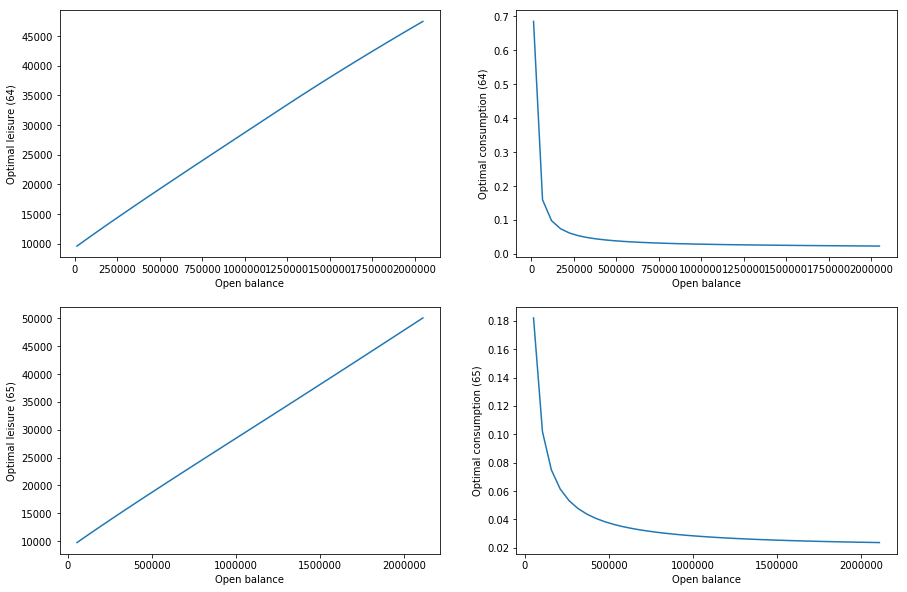

In [35]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(Optimal_results_VFI_2.column('M64'), Optimal_results_VFI_2.column('V64_adj'))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure (64)')

plt.subplot(2,2,2)
plt.plot(Optimal_results_VFI_2.column('M64'), Optimal_results_VFI_2.column('V64_adj') / Optimal_results_VFI_2.column('M64'))
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption (64)')

plt.subplot(2,2,3)
plt.plot(Optimal_results_VFI.column('M65'), Optimal_results_VFI.column('V65_adj'))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure (65)')

plt.subplot(2,2,4)
plt.plot(Optimal_results_VFI.column('M65'), Optimal_results_VFI.column('V65_adj') / Optimal_results_VFI.column('M65'))
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption (65)')

In [19]:
import time
start_time = time.time()

Optimal_results_VFI_2 = Table().with_columns([
    'M65', Optimal_results_VFI.column('M65'),
    'C65', Optimal_results_VFI.column('C65'),
    'L65', Optimal_results_VFI.column('L65'),
    'V65', Optimal_results_VFI.column('V65'),
    'V65_adj', Optimal_results_VFI.column('V65_adj'),
])

for i in range(40): ## age 64-25 --> i from 0 to 39 (include)
    def interpo(M_nt, table): # need to know which table to use
        func = interp1d(table.column(5*i+0), table.column(5*i+4), kind='linear', fill_value='extrapolate')
            ## change to cubic interpolation?
        V_next_adj = func(M_nt) 
        V_next = np.power(np.power(V_next_adj,α), 1-ρ) / (1-ρ)
        return V_next
    
    Mx = Start_bal_2.column(i)
    Optimal_results_VFI_2 = Optimal_results_VFI_2.with_column('M%(age)1d'%{'age':64-i}, Mx)
    
    Cx = []
    Lx = []
    Vx = []
    Vx_adj = []
    for node in Mx:
        guess_con = 5000 
        guess_lei = 0.3
        initial_guess = [guess_con, guess_lei] # this is very important

        opt = solve()
        while not opt.success:
            guess_con += 500 # * np.random.uniform(0.8,1.2)
#             guess_lei += np.random.uniform(-0.1,0.1)
            initial_guess = [guess_con, guess_lei]
            opt = solve()
            
        Cxx, Lxx = opt.x
        Cx.append(Cxx)
        Lx.append(Lxx)
        Vxx = - opt.fun / 1e18  # to minimize, previous use negative value function
        Vx.append(Vxx)
        Vxx_adj = transform(Vxx)
        Vx_adj.append(Vxx_adj)

    Optimal_results_VFI_2 = Optimal_results_VFI_2.with_column('C%(age)1d'%{'age':64-i}, Cx)
    Optimal_results_VFI_2 = Optimal_results_VFI_2.with_column('L%(age)1d'%{'age':64-i}, Lx)
    Optimal_results_VFI_2 = Optimal_results_VFI_2.with_column('V%(age)1d'%{'age':64-i}, Vx)
    Optimal_results_VFI_2 = Optimal_results_VFI_2.with_column('V%(age)1d_adj'%{'age':64-i}, Vx_adj)
    print('age%1d_finished!'%(64-i))

print("--- %s seconds ---" % (time.time() - start_time))

age64_finished!
age63_finished!
age62_finished!
age61_finished!
age60_finished!
age59_finished!
age58_finished!
age57_finished!
age56_finished!
age55_finished!
age54_finished!
age53_finished!
age52_finished!


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


age51_finished!
age50_finished!
age49_finished!
age48_finished!
age47_finished!
age46_finished!
age45_finished!
age44_finished!
age43_finished!
age42_finished!
age41_finished!
age40_finished!
age39_finished!
age38_finished!
age37_finished!
age36_finished!
age35_finished!
age34_finished!
age33_finished!
age32_finished!
age31_finished!
age30_finished!
age29_finished!
age28_finished!
age27_finished!
age26_finished!
age25_finished!
--- 45.19476246833801 seconds ---


Text(0,0.5,'Optimal consumption')

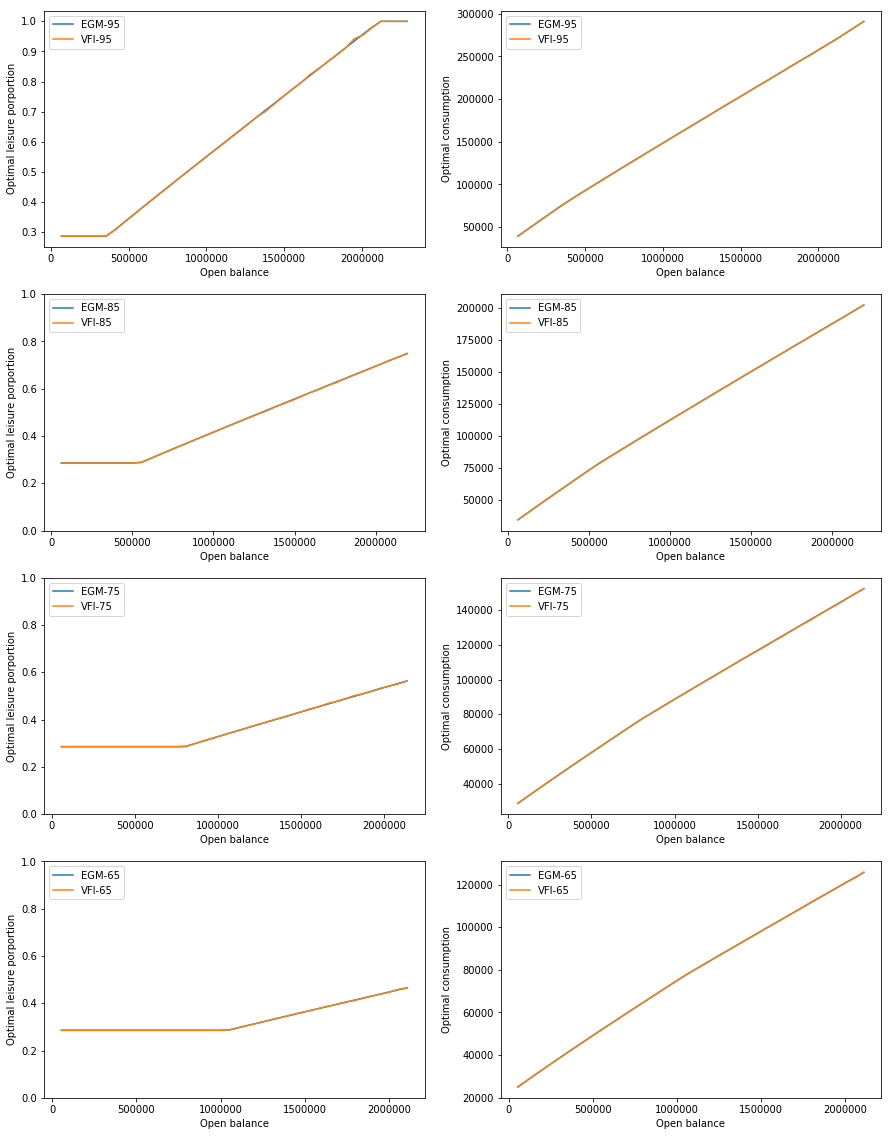

In [20]:
plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
plt.plot(Optimal_results_EGM['M95'], Optimal_results_EGM['L95'])
plt.plot(Optimal_results_VFI['M95'], Optimal_results_VFI['L95'])
plt.legend(['EGM-95','VFI-95'], loc='upper left')
# plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,2)
plt.plot(Optimal_results_EGM['M95'], Optimal_results_EGM['C95'])
plt.plot(Optimal_results_VFI['M95'], Optimal_results_VFI['C95'])
plt.legend(['EGM-95','VFI-95'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,3)
plt.plot(Optimal_results_EGM['M85'], Optimal_results_EGM['L85'])
plt.plot(Optimal_results_VFI['M85'], Optimal_results_VFI['L85'])
plt.legend(['EGM-85','VFI-85'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,4)
plt.plot(Optimal_results_EGM['M85'], Optimal_results_EGM['C85'])
plt.plot(Optimal_results_VFI['M85'], Optimal_results_VFI['C85'])
plt.legend(['EGM-85','VFI-85'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,5)
plt.plot(Optimal_results_EGM['M75'], Optimal_results_EGM['L75'])
plt.plot(Optimal_results_VFI['M75'], Optimal_results_VFI['L75'])
plt.legend(['EGM-75','VFI-75'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,6)
plt.plot(Optimal_results_EGM['M75'], Optimal_results_EGM['C75'])
plt.plot(Optimal_results_VFI['M75'], Optimal_results_VFI['C75'])
plt.legend(['EGM-75','VFI-75'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,7)
plt.plot(Optimal_results_EGM['M65'], Optimal_results_EGM['L65'])
plt.plot(Optimal_results_VFI['M65'], Optimal_results_VFI['L65'])
plt.legend(['EGM-65','VFI-65'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,8)
plt.plot(Optimal_results_EGM['M65'], Optimal_results_EGM['C65'])
plt.plot(Optimal_results_VFI['M65'], Optimal_results_VFI['C65'])
plt.legend(['EGM-65','VFI-65'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

# plt.savefig('EGMvsVFI, α=.9, 65-95.png')

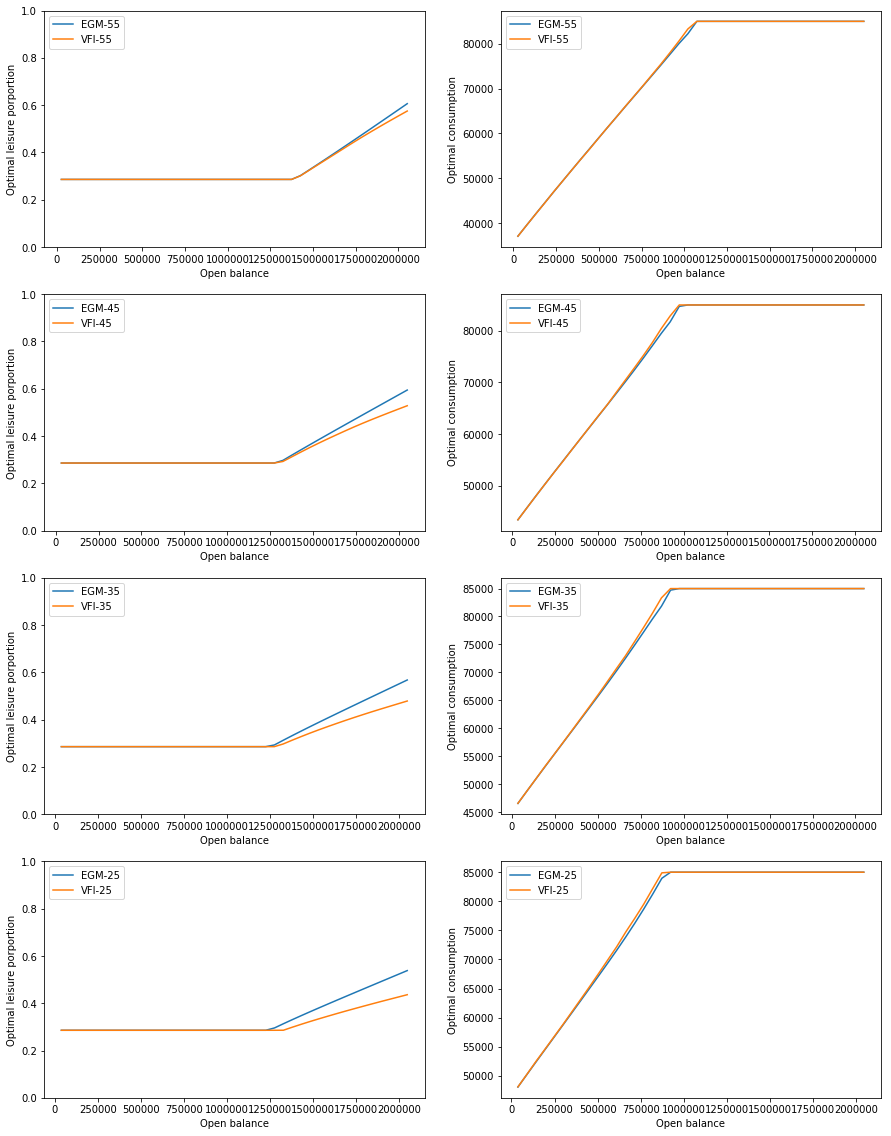

In [40]:
plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_results_EGM_25_63['L55'])
plt.plot(Optimal_results_VFI_2['M55'], Optimal_results_VFI_2['L55'])
plt.legend(['EGM-55','VFI-55'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,2)
plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_results_EGM_25_63['C55'])
plt.plot(Optimal_results_VFI_2['M55'], Optimal_results_VFI_2['C55'])
plt.legend(['EGM-55','VFI-55'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,3)
plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_results_EGM_25_63['L45'])
plt.plot(Optimal_results_VFI_2['M45'], Optimal_results_VFI_2['L45'])
plt.legend(['EGM-45','VFI-45'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,4)
plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_results_EGM_25_63['C45'])
plt.plot(Optimal_results_VFI_2['M45'], Optimal_results_VFI_2['C45'])
plt.legend(['EGM-45','VFI-45'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,5)
plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_results_EGM_25_63['L35'])
plt.plot(Optimal_results_VFI_2['M35'], Optimal_results_VFI_2['L35'])
plt.legend(['EGM-35','VFI-35'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,6)
plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_results_EGM_25_63['C35'])
plt.plot(Optimal_results_VFI_2['M35'], Optimal_results_VFI_2['C35'])
plt.legend(['EGM-35','VFI-35'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,7)
plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_results_EGM_25_63['L25'])
plt.plot(Optimal_results_VFI_2['M25'], Optimal_results_VFI_2['L25'])
plt.legend(['EGM-25','VFI-25'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,8)
plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_results_EGM_25_63['C25'])
plt.plot(Optimal_results_VFI_2['M25'], Optimal_results_VFI_2['C25'])
plt.legend(['EGM-25','VFI-25'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

# plt.savefig('figure 2.3.png')

In [39]:
Optimal_results_EGM_25_63.show(3)

A64,C64,L64,M64,C_un64,L_un64,A63,C63,L63,M63,C_un63,L_un63,A62,C62,L62,M62,C_un62,L_un62,A61,C61,L61,M61,C_un61,L_un61,A60,C60,L60,M60,C_un60,L_un60,A59,C59,L59,M59,C_un59,L_un59,A58,C58,L58,M58,C_un58,L_un58,A57,C57,L57,M57,C_un57,L_un57,A56,C56,L56,M56,C_un56,L_un56,A55,C55,L55,M55,C_un55,L_un55,A54,C54,L54,M54,C_un54,L_un54,A53,C53,L53,M53,C_un53,L_un53,A52,C52,L52,M52,C_un52,L_un52,A51,C51,L51,M51,C_un51,L_un51,A50,C50,L50,M50,C_un50,L_un50,A49,C49,L49,M49,C_un49,L_un49,A48,C48,L48,M48,C_un48,L_un48,A47,C47,L47,M47,C_un47,L_un47,A46,C46,L46,M46,C_un46,L_un46,A45,C45,L45,M45,C_un45,L_un45,A44,C44,L44,M44,C_un44,L_un44,A43,C43,L43,M43,C_un43,L_un43,A42,C42,L42,M42,C_un42,L_un42,A41,C41,L41,M41,C_un41,L_un41,A40,C40,L40,M40,C_un40,L_un40,A39,C39,L39,M39,C_un39,L_un39,A38,C38,L38,M38,C_un38,L_un38,A37,C37,L37,M37,C_un37,L_un37,A36,C36,L36,M36,C_un36,L_un36,A35,C35,L35,M35,C_un35,L_un35,A34,C34,L34,M34,C_un34,L_un34,A33,C33,L33,M33,C_un33,L_un33,A32,C32,L32,M32,C_un32,L_un32,A31,C31,L31,M31,C_un31,L_un31,A30,C30,L30,M30,C_un30,L_un30,A29,C29,L29,M29,C_un29,L_un29,A28,C28,L28,M28,C_un28,L_un28,A27,C27,L27,M27,C_un27,L_un27,A26,C26,L26,M26,C_un26,L_un26,A25,C25,L25,M25,C_un25,L_un25
50000,24725.6,0.285714,14011.3,24725.6,0.0384769,50000,26637.6,0.285714,15923.3,26637.6,0.0412061,50000,28376.9,0.285714,17662.6,28376.9,0.043675,50000,29962.1,0.285714,19247.8,29962.1,0.0459147,50000,31410.5,0.285714,20696.2,31410.5,0.0479529,50000,32737.2,0.285714,22022.9,32737.2,0.0498131,50000,33954.9,0.285714,23240.6,33954.9,0.0515153,50000,35074.9,0.285714,24360.6,35074.9,0.0530765,50000,36106.6,0.285714,25392.3,36106.6,0.0545112,50000,37058.4,0.285714,26344.1,37058.4,0.0558318,50000,37937.5,0.285714,27223.2,37937.5,0.0570492,50000,38750.3,0.285714,28036,38750.3,0.0581726,50000,39502.3,0.285714,28788,39502.3,0.0592105,50000,40198.9,0.285714,29484.6,40198.9,0.0601704,50000,40844.5,0.285714,30130.2,40844.5,0.0610589,50000,41443.3,0.285714,30729,41443.3,0.061882,50000,41999.2,0.285714,31284.9,41999.2,0.0626451,50000,42515.4,0.285714,31801.1,42515.4,0.0633532,50000,42995.1,0.285714,32280.8,42995.1,0.0640106,50000,43441.2,0.285714,32726.9,43441.2,0.0646212,50000,43856.1,0.285714,33141.8,43856.1,0.0651889,50000,44242.3,0.285714,33528,44242.3,0.0657168,50000,44601.9,0.285714,33887.6,44601.9,0.066208,50000,44936.8,0.285714,34222.5,44936.8,0.0666654,50000,45249,0.285714,34534.7,45249,0.0670913,50000,45540,0.285714,34825.7,45540,0.0674882,50000,45811.4,0.285714,35097.1,45811.4,0.0678581,50000,46064.6,0.285714,35350.3,46064.6,0.0682031,50000,46300.9,0.285714,35586.7,46300.9,0.0685249,50000,46521.6,0.285714,35807.3,46521.6,0.0688253,50000,46727.7,0.285714,36013.4,46727.7,0.0691058,50000,46920.2,0.285714,36206,46920.2,0.0693677,50000,47100.2,0.285714,36385.9,47100.2,0.0696125,50000,47268.4,0.285714,36554.2,47268.4,0.0698412,50000,47425.8,0.285714,36711.5,47425.8,0.070055,50000,47573,0.285714,36858.7,47573,0.070255,50000,47710.7,0.285714,36996.5,47710.7,0.0704422,50000,47839.8,0.285714,37125.5,47839.8,0.0706174,50000,47960.7,0.285714,37246.4,47960.7,0.0707816,50000,48074.1,0.285714,37359.8,48074.1,0.0709356
100000,27671.7,0.285714,66957.4,27671.7,0.0426755,100000,29514.4,0.285714,68800.1,29514.4,0.0452832,100000,31190,0.285714,70475.7,31190,0.0476431,100000,32718.2,0.285714,72003.9,32718.2,0.0497866,100000,34115.8,0.285714,73401.5,34115.8,0.0517398,100000,35396.8,0.285714,74682.6,35396.8,0.0535246,100000,36573.6,0.285714,75859.3,36573.6,0.0551595,100000,37656.5,0.285714,76942.2,37656.5,0.0566603,100000,38654.6,0.285714,77940.3,38654.6,0.0580404,100000,39575.6,0.285714,78861.3,39575.6,0.0593116,100000,40426.5,0.285714,79712.2,40426.5,0.0604838,100000,41213.2,0.285714,80499,41213.2,0.0615659,100000,41941.3,0.285714,81227,41941.3,0.0625657,100000,42615.5,0.285714,81901.3,42615.5,0.0634905,100000,43240.4,0.285714,82526.1,43240.4,0.0643465,100000,43819.9,0.285714,83105.6,43819.9,0.0651394,100000,44357.7,0.285714,83643.4,44357.7,0.0658745,100000,44857,0.285714,841

Text(0,0.5,'Optimal consumption')

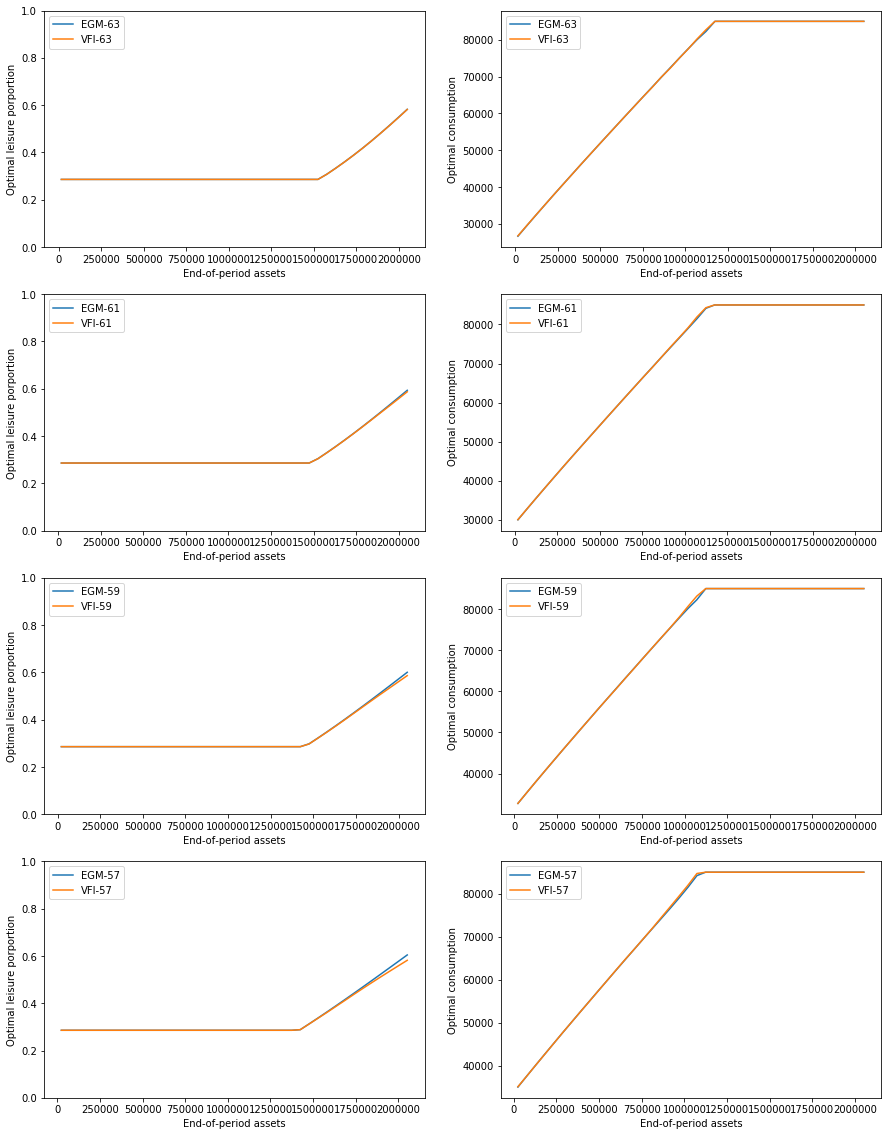

In [23]:
plt.figure(figsize=(15,20))
# plt.title('EGM vs VFI, α=.9, age 57-63')

plt.subplot(4,2,1)
plt.plot(Optimal_results_EGM_25_63['M63'], Optimal_results_EGM_25_63['L63'])
plt.plot(Optimal_results_VFI_2['M63'], Optimal_results_VFI_2['L63'])
plt.legend(['EGM-63','VFI-63'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('End-of-period assets')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,2)
plt.plot(Optimal_results_EGM_25_63['M63'], Optimal_results_EGM_25_63['C63'])
plt.plot(Optimal_results_VFI_2['M63'], Optimal_results_VFI_2['C63'])
plt.legend(['EGM-63','VFI-63'], loc='upper left')
plt.xlabel('End-of-period assets')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,3)
plt.plot(Optimal_results_EGM_25_63['M61'], Optimal_results_EGM_25_63['L61'])
plt.plot(Optimal_results_VFI_2['M61'], Optimal_results_VFI_2['L61'])
plt.legend(['EGM-61','VFI-61'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('End-of-period assets')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,4)
plt.plot(Optimal_results_EGM_25_63['M61'], Optimal_results_EGM_25_63['C61'])
plt.plot(Optimal_results_VFI_2['M61'], Optimal_results_VFI_2['C61'])
plt.legend(['EGM-61','VFI-61'], loc='upper left')
plt.xlabel('End-of-period assets')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,7)
plt.plot(Optimal_results_EGM_25_63['M57'], Optimal_results_EGM_25_63['L57'])
plt.plot(Optimal_results_VFI_2['M57'], Optimal_results_VFI_2['L57'])
plt.legend(['EGM-57','VFI-57'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('End-of-period assets')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,6)
plt.plot(Optimal_results_EGM_25_63['M59'], Optimal_results_EGM_25_63['C59'])
plt.plot(Optimal_results_VFI_2['M59'], Optimal_results_VFI_2['C59'])
plt.legend(['EGM-59','VFI-59'], loc='upper left')
plt.xlabel('End-of-period assets')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,5)
plt.plot(Optimal_results_EGM_25_63['M59'], Optimal_results_EGM_25_63['L59'])
plt.plot(Optimal_results_VFI_2['M59'], Optimal_results_VFI_2['L59'])
plt.legend(['EGM-59','VFI-59'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('End-of-period assets')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,8)
plt.plot(Optimal_results_EGM_25_63['M57'], Optimal_results_EGM_25_63['C57'])
plt.plot(Optimal_results_VFI_2['M57'], Optimal_results_VFI_2['C57'])
plt.legend(['EGM-57','VFI-57'], loc='upper left')
plt.xlabel('End-of-period assets')
plt.ylabel('Optimal consumption')


# plt.savefig('EGMvsVFI, α=.9, 57-63.png')

Text(0,0.5,'Optimal consumption')

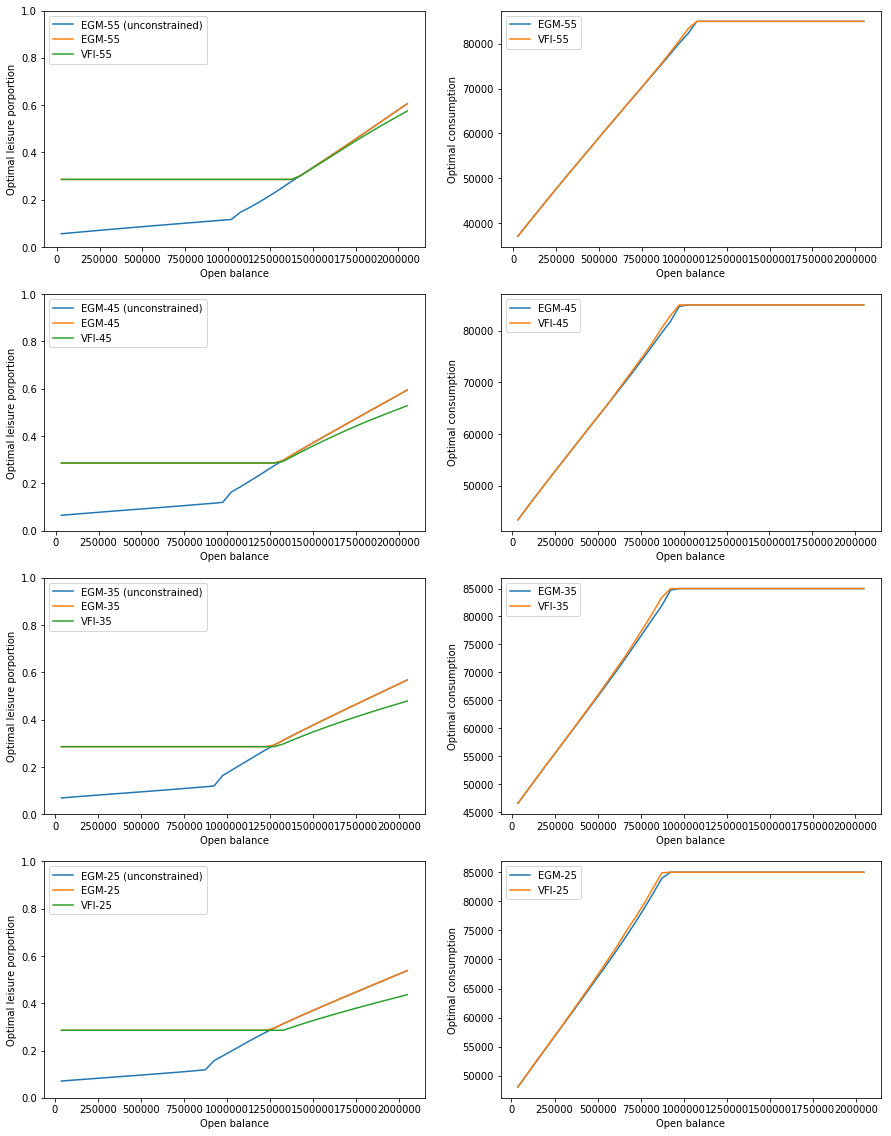

In [38]:
plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_results_EGM_25_63['L_un55'])
plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_results_EGM_25_63['L55'])
plt.plot(Optimal_results_VFI_2['M55'], Optimal_results_VFI_2['L55'])
plt.legend(['EGM-55 (unconstrained)','EGM-55','VFI-55'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,2)
plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_results_EGM_25_63['C55'])
plt.plot(Optimal_results_VFI_2['M55'], Optimal_results_VFI_2['C55'])
plt.legend(['EGM-55','VFI-55'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,3)
plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_results_EGM_25_63['L_un45'])
plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_results_EGM_25_63['L45'])
plt.plot(Optimal_results_VFI_2['M45'], Optimal_results_VFI_2['L45'])
plt.legend(['EGM-45 (unconstrained)','EGM-45','VFI-45'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,4)
plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_results_EGM_25_63['C45'])
plt.plot(Optimal_results_VFI_2['M45'], Optimal_results_VFI_2['C45'])
plt.legend(['EGM-45','VFI-45'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,5)
plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_results_EGM_25_63['L_un35'])
plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_results_EGM_25_63['L35'])
plt.plot(Optimal_results_VFI_2['M35'], Optimal_results_VFI_2['L35'])
plt.legend(['EGM-35 (unconstrained)','EGM-35','VFI-35'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,6)
plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_results_EGM_25_63['C35'])
plt.plot(Optimal_results_VFI_2['M35'], Optimal_results_VFI_2['C35'])
plt.legend(['EGM-35','VFI-35'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,7)
plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_results_EGM_25_63['L_un25'])
plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_results_EGM_25_63['L25'])
plt.plot(Optimal_results_VFI_2['M25'], Optimal_results_VFI_2['L25'])
plt.legend(['EGM-25 (unconstrained)','EGM-25','VFI-25'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,8)
plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_results_EGM_25_63['C25'])
plt.plot(Optimal_results_VFI_2['M25'], Optimal_results_VFI_2['C25'])
plt.legend(['EGM-25','VFI-25'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

# plt.savefig('EGMvsVFI, α=.9, 25-55.png')